# Creating hot gas density profiles and measuring gas mass

Though this work is generally concerned with detected absorption of background quasar emission by warm gas in the intra-cluster/group medium, it also seemed appropriate to measure the quantity of hot, X-ray emitting, gas present in the intra-cluster medium. This involves creating a density profile, and there is a method (using surface brightness profiles) which can be used with low signal-to-noise extended sources. We then calculate the total gas mass by spherically integrating that profile within overdensity radii for all of our systems.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
import os
from shutil import rmtree
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/radial_prof_analyses')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model
from xga.products import BaseAggregateProfile1D
from xga.utils import r500 as r500_unit
    
%matplotlib inline

## Setting up directories

Need to make sure that some of the directories that we will be storing output files and figures in actually exist:

In [2]:
if not os.path.exists('../../outputs/results/'):
    os.makedirs('../../outputs/results/')
    
if not os.path.exists('../../outputs/figures/gm_prop_comparisons/'):
    os.makedirs('../../outputs/figures/gm_prop_comparisons/')

## Reading the XGA sample files

We read in the files generated by our various runs of the XGA-LTR in another notebook in this repository. They contain the radii we measured, as well as all the other information that we need to declare an XGA ClusterSample:

In [3]:
r500_samp = pd.read_csv('../../outputs/results/ltr_r500_pipeline_results.csv')
r500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r500_froztemp_pipeline_results.csv')

r2500_samp = pd.read_csv('../../outputs/results/ltr_r2500_pipeline_results.csv')
r2500_froztemp_samp = pd.read_csv('../../outputs/results/ltr_r2500_froztemp_pipeline_results.csv')

We show one of the dataframes to illustrate the contents:

In [4]:
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124A,243.629055,26.730240,0.186,867.647767,39.128436,3.817000,0.287230,0.326195,7.396831e+43,1.360925e+42,1.402886e+42,2.126068e+44,1.169875e+43,7.694207e+42,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42
1,25124B,243.504000,26.691000,0.186,665.433860,93.790303,2.121080,0.453657,1.097385,4.858143e+42,5.199192e+41,8.079419e+41,1.105362e+43,1.375212e+42,1.947342e+42,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42
2,25124C,243.541000,26.648000,0.186,504.349762,26.563232,1.505450,0.118645,0.157002,4.980125e+42,3.866127e+41,5.769732e+41,1.016123e+43,9.850380e+41,1.368388e+42,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42
3,44739,229.793620,28.331750,0.118,426.978169,22.844914,1.024810,0.066587,0.081072,2.328422e+42,2.278838e+41,2.520566e+41,4.075968e+42,4.683800e+41,5.811503e+41,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41
4,19670AB,150.226402,50.800565,0.134,527.139938,30.952352,1.978950,0.341111,0.660766,3.495482e+42,3.820188e+41,5.467797e+41,7.810693e+42,9.568825e+41,1.398974e+42,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42
5,19670A,150.256710,50.793942,0.134,462.177328,27.670531,1.252010,0.113311,0.139826,1.581114e+42,2.128492e+41,3.223873e+41,3.026369e+42,7.463168e+41,7.445787e+41,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41
6,19670B,150.214920,50.805014,0.134,591.610814,44.926843,1.907300,0.243713,0.425694,4.533795e+42,3.011521e+41,5.608558e+41,1.001424e+43,9.733266e+41,1.244323e+42,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41
7,19670C,150.065000,50.746000,0.134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,19670D,150.168000,50.686000,0.134,359.762893,58.758058,0.326002,0.070427,0.247115,7.776962e+41,4.208098e+41,1.206647e+41,1.484812e+42,7.575129e+41,3.734298e+41,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41
9,12833A,129.496800,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,4.326240e+41,2.991426e+41,6.828256e+42,9.969550e+41,7.096560e+41,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41


We remove the two entries with NaN $R_{500}$ values:

In [5]:
r500_samp = r500_samp[~np.isnan(r500_samp['r500'])].reset_index(drop=True)
r500_samp

,name,ra,dec,redshift,r500,r500+-,Tx500,Tx500-,Tx500+,Lx500_0.5-2.0,Lx500_0.5-2.0-,Lx500_0.5-2.0+,Lx500_0.01-100.0,Lx500_0.01-100.0-,Lx500_0.01-100.0+,Tx500ce,Tx500ce-,Tx500ce+,Lx500ce_0.5-2.0,Lx500ce_0.5-2.0-,Lx500ce_0.5-2.0+,Lx500ce_0.01-100.0,Lx500ce_0.01-100.0-,Lx500ce_0.01-100.0+
0,25124A,243.629055,26.730240,0.186,867.647767,39.128436,3.817000,0.287230,0.326195,7.396831e+43,1.360925e+42,1.402886e+42,2.126068e+44,1.169875e+43,7.694207e+42,4.240060,0.463875,0.698658,4.661778e+43,1.474055e+42,1.136021e+42,1.407295e+44,1.243112e+43,8.999482e+42
1,25124B,243.504000,26.691000,0.186,665.433860,93.790303,2.121080,0.453657,1.097385,4.858143e+42,5.199192e+41,8.079419e+41,1.105362e+43,1.375212e+42,1.947342e+42,1.668870,0.571085,1.111938,3.756145e+42,5.779736e+41,7.552022e+41,7.921396e+42,1.571571e+42,1.660467e+42
2,25124C,243.541000,26.648000,0.186,504.349762,26.563232,1.505450,0.118645,0.157002,4.980125e+42,3.866127e+41,5.769732e+41,1.016123e+43,9.850380e+41,1.368388e+42,1.475180,0.123717,0.146730,4.692879e+42,3.996000e+41,5.333483e+41,9.510069e+42,9.116242e+41,1.309781e+42
3,44739,229.793620,28.331750,0.118,426.978169,22.844914,1.024810,0.066587,0.081072,2.328422e+42,2.278838e+41,2.520566e+41,4.075968e+42,4.683800e+41,5.811503e+41,0.993314,0.088181,0.086573,1.873450e+42,2.306554e+41,2.767644e+41,3.233224e+42,3.960150e+41,4.341351e+41
4,19670AB,150.226402,50.800565,0.134,527.139938,30.952352,1.978950,0.341111,0.660766,3.495482e+42,3.820188e+41,5.467797e+41,7.810693e+42,9.568825e+41,1.398974e+42,1.561920,0.179030,0.293561,2.992024e+42,3.335254e+41,3.754196e+41,6.209580e+42,1.028791e+42,1.035156e+42
5,19670A,150.256710,50.793942,0.134,462.177328,27.670531,1.252010,0.113311,0.139826,1.581114e+42,2.128492e+41,3.223873e+41,3.026369e+42,7.463168e+41,7.445787e+41,1.333620,0.148756,0.199910,1.176707e+42,3.641293e+41,3.858331e+41,2.310265e+42,7.379632e+41,6.230597e+41
6,19670B,150.214920,50.805014,0.134,591.610814,44.926843,1.907300,0.243713,0.425694,4.533795e+42,3.011521e+41,5.608558e+41,1.001424e+43,9.733266e+41,1.244323e+42,1.652700,0.244968,0.313360,3.512372e+42,3.266195e+41,5.632695e+41,7.421187e+42,8.747499e+41,8.987884e+41
7,19670D,150.168000,50.686000,0.134,359.762893,58.758058,0.326002,0.070427,0.247115,7.776962e+41,4.208098e+41,1.206647e+41,1.484812e+42,7.575129e+41,3.734298e+41,0.246174,0.060497,0.107147,6.906259e+41,4.756693e+41,1.577939e+41,1.729986e+42,1.048810e+42,5.710794e+41
8,12833A,129.496800,44.248700,0.145,484.161429,22.267250,1.394590,0.098024,0.113226,3.419655e+42,4.326240e+41,2.991426e+41,6.828256e+42,9.969550e+41,7.096560e+41,1.416080,0.145301,0.239000,2.240773e+42,3.645432e+41,2.770394e+41,4.498901e+42,7.032202e+41,5.884023e+41
9,12833B,129.445000,44.379000,0.145,435.477156,26.364544,1.161630,0.135227,0.116765,2.511945e+42,2.677573e+41,3.283677e+41,4.654556e+42,7.296128e+41,8.407739e+41,0.926943,0.120020,0.134047,1.378771e+42,3.555113e+41,3.233896e+41,2.309754e+42,5.456964e+41,3.761557e+41


## Setting up an XGA ClusterSample

We set up an XGA ClusterSample object for our systems - this will allow us to easily interact with all the XMM data for these objects, and perform measurements of their hot-gas density profiles. We make sure to set `use_peak=False`, so that the user defined coordinate (UDC) is used as the central position, as some of these systems are low enough signal to noise that they may produce unreliable peak coordinates:

In [6]:
srcs = ClusterSample(r500_samp['ra'].values, r500_samp['dec'].values, r500_samp['redshift'].values, 
                     r500_samp['name'].values, r500=Quantity(r500_samp['r500'].values, 'kpc'), 
                     use_peak=False, load_fits=True)
srcs.info()
srcs.suppressed_warnings

Setting up Galaxy Clusters: 100%|██████████| 14/14 [00:13<00:00,  1.07it/s]


-----------------------------------------------------
Number of Sources - 14
Redshift Information - True
Sources with ≥1 detection - 12 [86%]
-----------------------------------------------------




/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:279: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


{'44739': ['There are 1 alternative matches for observation 0900700201, associated with source 44739'],
 '19670A': ['There are 1 alternative matches for observation 0861080101, associated with source 19670A'],
 '19670B': ['A point source has been detected in 0861080101 and is very close to the user supplied coordinates of 19670B. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 'J215504.8-093520': ["J215504.8-093520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data"],
 'J215437.2-091532.4': ['A PSF sized extended source has been detected in 0204310101 and is very close to the user supplied coordinates of J215437.2-091532.4. It will not be excluded from analysis due to the possibility of a mis-identified cool core'],
 '50433': ['There are 1 alternative matches for observation 0102040301, associated with source 50433']}

## Generating hot gas density profiles

We generate surface brightness profiles, from ratemaps that have been corrected for the spatially varying PSF, and fit a simple $\beta$ model to them. This is inverse Abel transformed to recover a 3D emissivity profile, which in turn is used to calculate a 3D hot-baryon density profile with assumptions made about the emission model for the gas.

We have decided to generate the profiles to an outer radius of $1R_{500}$, where the $R_{500}$ in question is that measured from the 'standard' XGA-LTR run. As this process requires spectral information to work, we tell it to use `min_counts=25`, so that it should use previously generated spectra. 

We're also going to pass the temperatures that were measured by the XGA-LTR, so as to be totally consistent (there we used a non-standard energy range for the spectral fits that we cannot pass to this function currently):

In [7]:
txs = Quantity([r500_samp[r500_samp['name'] == src.name].iloc[0]['Tx500'] for src in srcs], 'keV')
txs

<Quantity [3.817   , 2.12108 , 1.50545 , 1.02481 , 1.97895 , 1.25201 ,
           1.9073  , 0.326002, 1.39459 , 1.16163 , 2.01986 , 1.72782 ,
           0.350344, 1.26242 ] keV>

### PSF Corrected

Then we run the actual density profile generation:

In [8]:
rl_psf(srcs, bins=10)
d_profs = inv_abel_fitted_model(srcs, 'beta', outer_radius=srcs.r500, psf_bins=10, pix_step=2, min_counts=25, 
                                conv_temp=txs)

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:  21%|██▏       | 3/14 [00:47<02:53, 15.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [204.95841186 247.19573288 501.93045063]


Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 14/14 [03:48<00:00, 16.31s/it]


Viewing the surface brightness profiles:

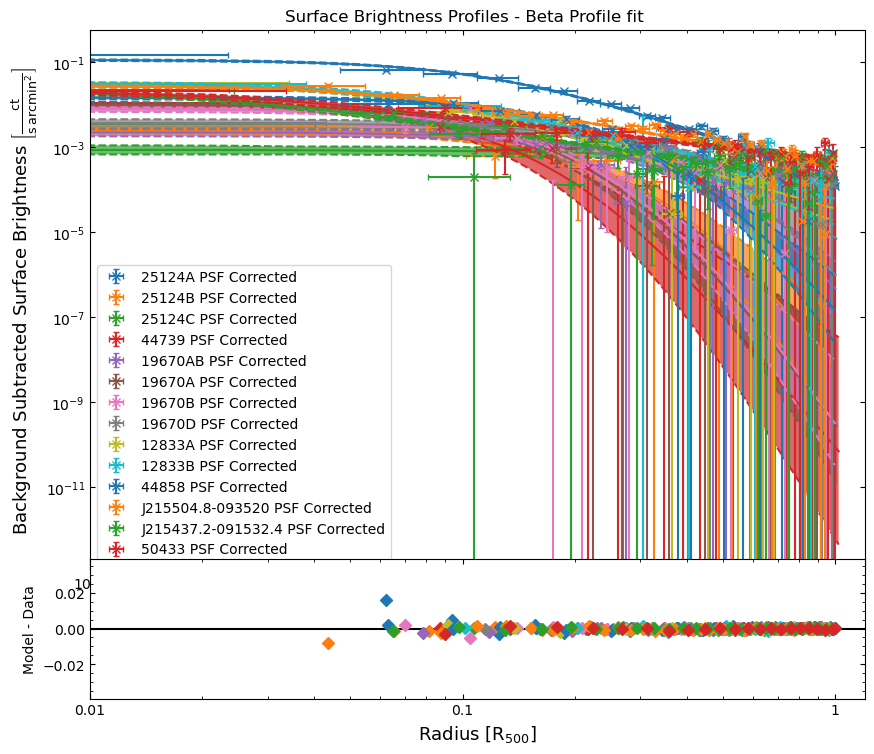

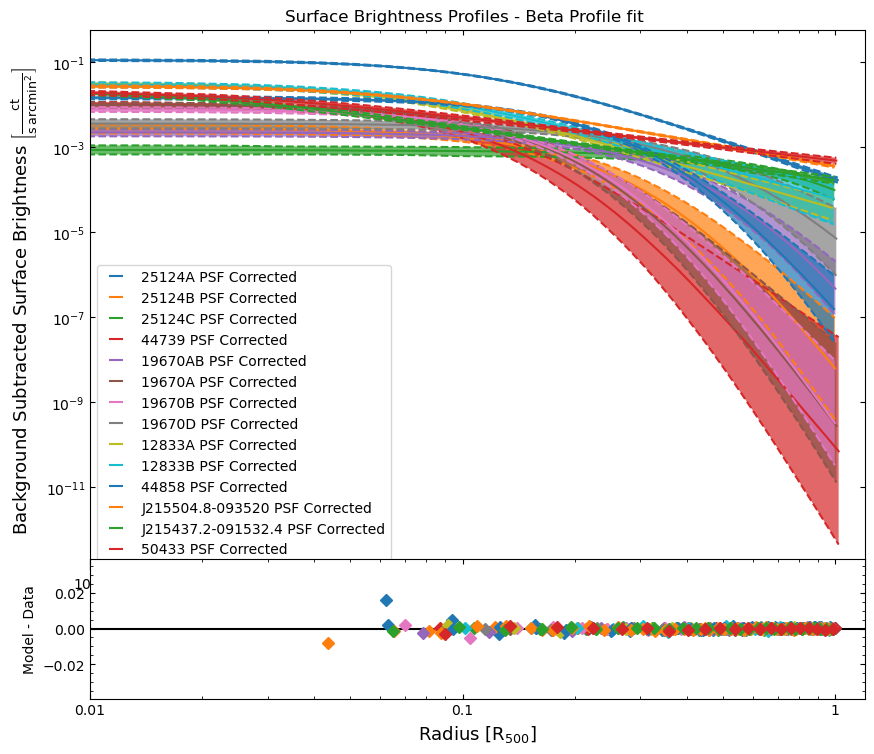

In [9]:
sb_profs = []
for dp in d_profs:
    if dp is not None:
        dp.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        dp.generation_profile.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        sb_profs.append(dp.generation_profile)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
BaseAggregateProfile1D(sb_profs).view(model='beta', just_model=False, x_norm=True, axis_formatters=forms, 
                                      xlim=[0.01, 1.2], save_path='../../outputs/figures/sb_profs.pdf')
BaseAggregateProfile1D(sb_profs).view(model='beta', just_model=True, x_norm=True, axis_formatters=forms, 
                                      xlim=[0.01, 1.2], save_path='../../outputs/figures/sb_profs_justmod.pdf')

We also view the generated density profiles on one figure, and then save it to disk:

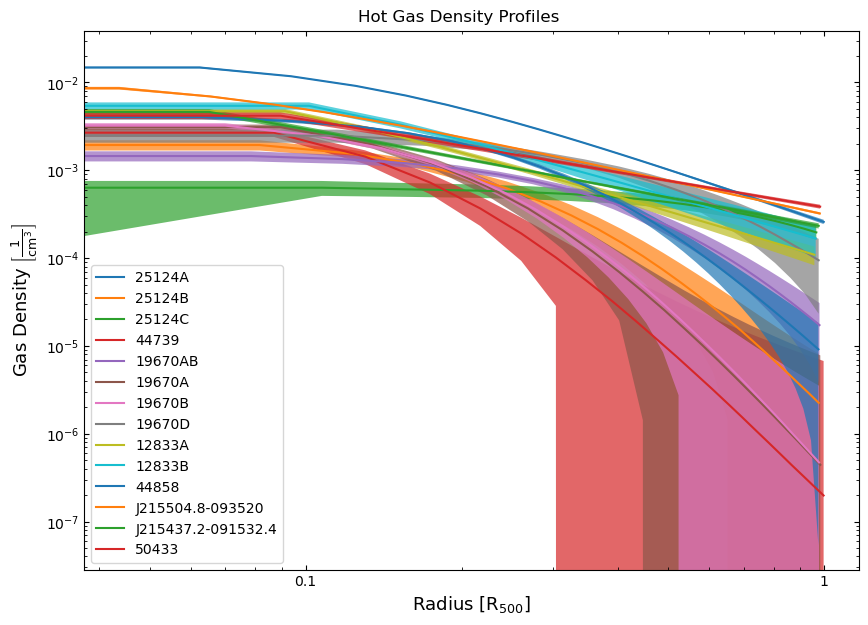

In [10]:
agg_dp = BaseAggregateProfile1D([dp for dp in d_profs if dp is not None])

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
agg_dp.view(joined_points=True, custom_title='Hot Gas Density Profiles', x_norm=True, axis_formatters=forms,
            save_path='../../outputs/figures/hot_gas_dens_profs.pdf')

### Non-PSF Corrected

In [8]:
d_profs_nocorr = inv_abel_fitted_model(srcs, 'beta', outer_radius=srcs.r500, pix_step=2, min_counts=25, 
                                       conv_temp=txs, psf_corr=False)

/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities: 100%|██████████| 14/14 [03:48<00:00, 16.33s/it]


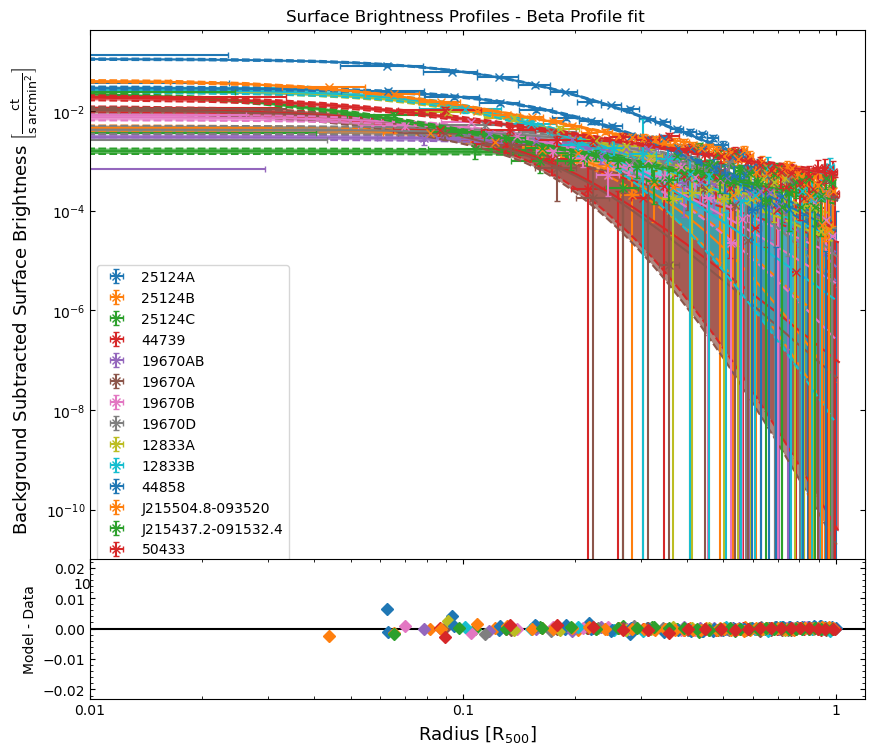

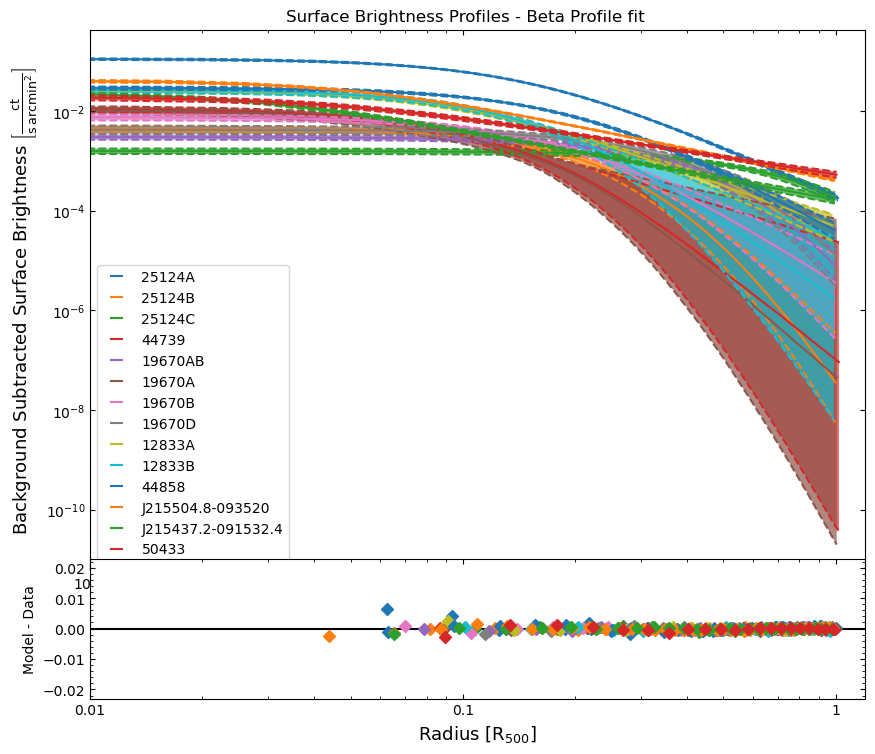

In [9]:
sb_profs_nocorr = []
for dp in d_profs_nocorr:
    if dp is not None:
        dp.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        dp.generation_profile.x_norm = srcs[dp.src_name].r500 / Quantity(1, r500_unit)
        sb_profs_nocorr.append(dp.generation_profile)

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
BaseAggregateProfile1D(sb_profs_nocorr).view(model='beta', just_model=False, x_norm=True, axis_formatters=forms, 
                                             xlim=[0.01, 1.2])
# , save_path='../../outputs/figures/sb_profs.pdf'
BaseAggregateProfile1D(sb_profs_nocorr).view(model='beta', just_model=True, x_norm=True, axis_formatters=forms, 
                                             xlim=[0.01, 1.2])
# , save_path='../../outputs/figures/sb_profs_justmod.pdf'

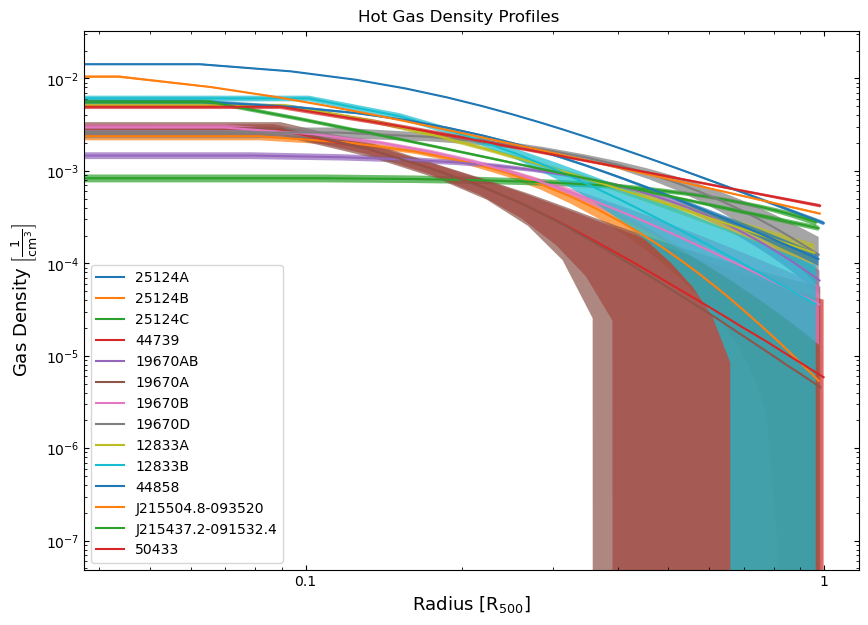

In [10]:
agg_dp = BaseAggregateProfile1D([dp for dp in d_profs_nocorr if dp is not None])

forms = {'xmajor': FuncFormatter(lambda inp, _: '{:g}'.format(inp))}
agg_dp.view(joined_points=True, custom_title='Hot Gas Density Profiles', x_norm=True, axis_formatters=forms)
# , save_path='../../outputs/figures/hot_gas_dens_profs.pdf'

## Showing brightness profile model parameters

We want to save the model parameters that describe each surface brightness profile to disk in a table (rather than just in the profile objects that XGA automatically saves to disk):

In [11]:
data = []
cols = ['name', 'beta', 'beta-', 'beta+', 'r_core', 'r_core-', 'r_core+','norm', 'norm-', 'norm+']
for src_ind, src in enumerate(srcs):
    if d_profs[src_ind] is not None:
        sb = d_profs[src_ind].generation_profile
        mod = sb.get_model_fit('beta', 'mcmc')
        par_vals = mod.model_pars
        par_errs = mod.model_par_errs
        cur_dat = [src.name, par_vals[0].value, *par_errs[0].value, par_vals[1].value, *par_errs[1].value, 
                   par_vals[2].value, *par_errs[2].value]
    else:
        cur_dat = [src.name] + [np.NaN]*9
    data.append(cur_dat)

print(mod.par_names)
print(mod.par_units)
    
sb_mod_df = pd.DataFrame(data, columns=cols).round(3)
sb_mod_df.to_csv("../../outputs/results/sb_beta_mod_pars.csv", index=False)
sb_mod_df

['beta', 'r_core', 'norm']
[Unit(dimensionless), Unit("kpc"), Unit("ct / (arcmin2 s)")]


,name,beta,beta-,beta+,r_core,r_core-,r_core+,norm,norm-,norm+
0,25124A,0.684,0.022,0.024,108.539,6.348,7.028,0.114,0.005,0.005
1,25124B,2.136,0.717,0.568,229.124,58.310,57.830,0.003,0.001,0.001
2,25124C,1.934,0.951,0.657,678.142,243.054,192.402,0.001,0.000,0.000
3,44739,1.917,0.809,0.715,72.309,23.729,20.046,0.010,0.002,0.002
4,19670AB,2.176,0.729,0.516,295.832,68.771,60.833,0.002,0.000,0.000
5,19670A,2.107,0.777,0.568,108.307,28.561,21.812,0.010,0.001,0.002
6,19670B,2.250,0.665,0.475,158.778,32.230,23.393,0.008,0.001,0.001
7,19670D,1.817,0.885,0.811,213.616,81.157,82.364,0.004,0.001,0.001
8,12833A,0.599,0.054,0.072,33.931,5.623,6.919,0.032,0.003,0.003
9,12833B,0.646,0.079,0.165,38.063,8.913,14.263,0.031,0.004,0.004


In [12]:
form_str = "${v}^{{+{p}}}_{{-{m}}}$"

tab_str = ""
for row_ind, row in sb_mod_df.iterrows():
    row_val = row.values.astype(str)
    beta_str = form_str.format(v=row_val[1], m=row_val[2], p=row_val[3])
    rc_str = form_str.format(v=row_val[4], m=row_val[5], p=row_val[6])
    n_str = form_str.format(v=row_val[7], m=row_val[8], p=row_val[9])    

    cur_line = row_val[0] + ' & ' + beta_str + ' & ' + rc_str + ' & ' + n_str + '\\\[1.5mm]\n%\n'
    tab_str += cur_line
print(tab_str)

25124A & $0.684^{+0.024}_{-0.022}$ & $108.539^{+7.028}_{-6.348}$ & $0.114^{+0.005}_{-0.005}$\\[1.5mm]
%
25124B & $2.136^{+0.568}_{-0.717}$ & $229.124^{+57.83}_{-58.31}$ & $0.003^{+0.001}_{-0.001}$\\[1.5mm]
%
25124C & $1.934^{+0.657}_{-0.951}$ & $678.142^{+192.402}_{-243.054}$ & $0.001^{+0.0}_{-0.0}$\\[1.5mm]
%
44739 & $1.917^{+0.715}_{-0.809}$ & $72.309^{+20.046}_{-23.729}$ & $0.01^{+0.002}_{-0.002}$\\[1.5mm]
%
19670AB & $2.176^{+0.516}_{-0.729}$ & $295.832^{+60.833}_{-68.771}$ & $0.002^{+0.0}_{-0.0}$\\[1.5mm]
%
19670A & $2.107^{+0.568}_{-0.777}$ & $108.307^{+21.812}_{-28.561}$ & $0.01^{+0.002}_{-0.001}$\\[1.5mm]
%
19670B & $2.25^{+0.475}_{-0.665}$ & $158.778^{+23.393}_{-32.23}$ & $0.008^{+0.001}_{-0.001}$\\[1.5mm]
%
19670D & $1.817^{+0.811}_{-0.885}$ & $213.616^{+82.364}_{-81.157}$ & $0.004^{+0.001}_{-0.001}$\\[1.5mm]
%
12833A & $0.599^{+0.072}_{-0.054}$ & $33.931^{+6.919}_{-5.623}$ & $0.032^{+0.003}_{-0.003}$\\[1.5mm]
%
12833B & $0.646^{+0.165}_{-0.079}$ & $38.063^{+14.263}_{-8.913}$

## Measuring hot gas mass

Now that we have generated 3D density profiles, it is trivial to calculate the gas mass enclosed within some radii. This is done for the $R_{500}$ and $R_{2500}$ results of the three different ways that we ran the XGA-LTR:

In [13]:
gm500 = []
gm2500 = []
froztemp_gm500 = []
froztemp_gm2500 = []

for dp in d_profs:
    if dp is not None:
        rel_src = srcs[dp.src_name]
        dp.fit('king', progress_bar=False)
        r500_err = Quantity(r500_samp[r500_samp['name'] == rel_src.name].iloc[0]['r500+-'], 'kpc')
        gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
        
        rel_rad = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500'], 'kpc')
        rel_rad_err = Quantity(r2500_samp[r2500_samp['name'] == rel_src.name].iloc[0]['r2500+-'], 'kpc')
        gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        rel_rad = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == rel_src.name].iloc[0]['r500'], 'kpc')
        rel_rad_err = Quantity(r500_froztemp_samp[r500_froztemp_samp['name'] == 
                                                  rel_src.name].iloc[0]['r500+-'], 'kpc')
        froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
        
        rel_rad = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == rel_src.name].iloc[0]['r2500'], 
                           'kpc')
        rel_rad_err = Quantity(r2500_froztemp_samp[r2500_froztemp_samp['name'] == 
                                                   rel_src.name].iloc[0]['r2500+-'], 'kpc')
        froztemp_gm2500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
        
    else:
        null_res = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
        gm500.append(null_res)
        gm2500.append(null_res)
        froztemp_gm500.append(null_res)
        froztemp_gm2500.append(null_res)
    
gm500 = Quantity(gm500)
gm500[gm500 == 0] = np.NaN
gm2500 = Quantity(gm2500)
gm2500[gm2500 == 0] = np.NaN

froztemp_gm500 = Quantity(froztemp_gm500)
froztemp_gm500[froztemp_gm500 == 0] = np.NaN
froztemp_gm2500 = Quantity(froztemp_gm2500)
froztemp_gm2500[froztemp_gm2500 == 0] = np.NaN

/tmp/local/32705554/ipykernel_114313/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/32705554/ipykernel_114313/1280221148.py:20: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  froztemp_gm500.append(dp.gas_mass('king', rel_rad, radius_err=rel_rad_err)[0])
/tmp/local/32705554/ipykernel_114313/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or equal to the outer radius covered by the data, so you are effectively extrapolating using the model.
  gm500.append(dp.gas_mass('king', rel_src.r500, radius_err=r500_err)[0])
/tmp/local/32705554/ipykernel_114313/1280221148.py:11: UserWarning: The outer radius you supplied is greater than or 

## Saving gas masses

Now that we have measured the gas masses, we wish to save them to a csv:

In [14]:
gm_data = (np.hstack([gm500, gm2500, froztemp_gm500, 
                     froztemp_gm2500]).value / 1e+13).round(4)
gm_data = np.hstack([srcs.names[..., None], gm_data])

gm_cols = ['name', 'gm500', 'gm500-', 'gm500+', 'gm2500', 'gm2500-', 'gm2500+', 
           'gm_froztemp500', 'gm_froztemp500-', 'gm_froztemp500+', 'gm_froztemp2500', 'gm_froztemp2500-', 
           'gm_froztemp2500+']

gm_pd = pd.DataFrame(gm_data, columns=gm_cols)
gm_pd.to_csv("../../outputs/results/all_hot_gm_measurements.csv", index=False)
gm_pd

,name,gm500,gm500-,gm500+,gm2500,gm2500-,gm2500+,gm_froztemp500,gm_froztemp500-,gm_froztemp500+,gm_froztemp2500,gm_froztemp2500-,gm_froztemp2500+
0,25124A,2.7412,0.1464,0.1433,0.8997,0.0461,0.0455,2.7586,0.0591,0.0582,1.0464,0.0221,0.0221
1,25124B,0.0835,0.0086,0.0086,0.0624,0.0058,0.0061,0.0813,0.0076,0.0077,0.0561,0.0043,0.0046
2,25124C,0.2427,0.025,0.0259,0.0645,0.0107,0.0115,0.3012,0.0229,0.0244,0.0511,0.0053,0.0056
3,44739,0.008,0.0013,0.0015,0.0077,0.0011,0.0011,0.008,0.0013,0.0016,0.0079,0.0012,0.0013
4,19670AB,0.1037,0.0064,0.0068,0.0603,0.0051,0.005,0.1042,0.0063,0.0066,0.058,0.0036,0.0036
5,19670A,0.0191,0.0022,0.0026,0.0178,0.0017,0.0018,0.0191,0.0022,0.0026,0.0179,0.0016,0.0017
6,19670B,0.0438,0.0031,0.0031,0.04,0.0021,0.0022,0.0438,0.003,0.003,0.0388,0.0019,0.0019
7,19670D,0.0915,0.0128,0.0135,0.0801,0.0105,0.0106,0.1058,0.0135,0.0169,0.0669,0.005,0.0053
8,12833A,0.1661,0.0117,0.012,0.0588,0.0034,0.0034,0.1989,0.013,0.0136,0.0761,0.0041,0.0041
9,12833B,0.1772,0.0181,0.02,nan,nan,nan,0.2204,0.0214,0.0225,nan,nan,nan


## Comparing hot gas masses

As discussed in the XGA-LTR notebook elsewhere in this repository, we have run the pipeline which measures overdensity radii in three different modes, which results in slightly different values - as we measure the hot gas mass within a particular radius we compare the results from all the different versions of $R_{500}$ and $R_{2500}$:

In [15]:
stand_col = 'tab:cyan'
froztemp_col = 'firebrick'

### $R_{500}$

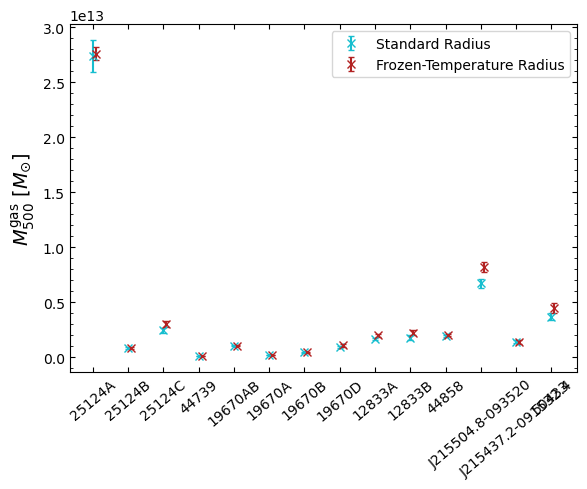

In [16]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm500[:, 0].value, yerr=gm500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm500[:, 0].value, 
             yerr=froztemp_gm500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm500_comp.pdf')
plt.show()

### $R_{2500}$

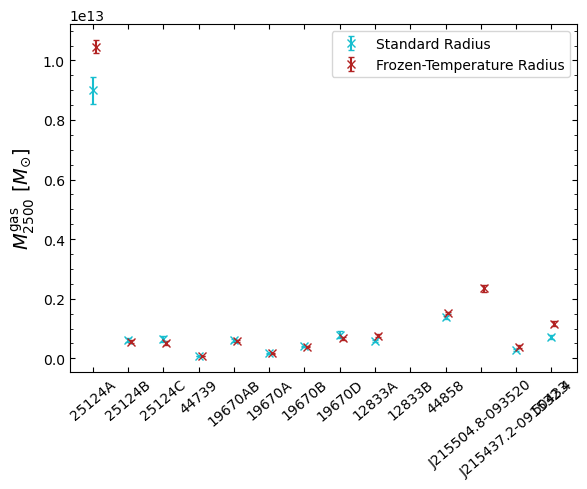

In [17]:
x_offset = 0.08

plt.figure(figsize=(6, 5))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(which='minor', axis='x', bottom=False, top=False)

plt.errorbar(range(len(srcs)), gm2500[:, 0].value, yerr=gm2500[:, 1:].T.value, fmt='x', label="Standard Radius", 
             color=stand_col, capsize=2)

plt.errorbar(np.array(range(len(srcs))) + x_offset, froztemp_gm2500[:, 0].value, 
             yerr=froztemp_gm2500[:, 1:].T.value, fmt='x', 
             label="Frozen-Temperature Radius", color=froztemp_col, capsize=2)

plt.ylabel(r"$M^{\rm{gas}}_{2500}$ [$M_{\odot}$]", fontsize=14)

plt.xticks(ticks=range(len(srcs)), labels=srcs.names)
ax = plt.gca()
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=40, horizontalalignment='center')

plt.legend()
plt.tight_layout()

plt.savefig('../../outputs/figures/gm_prop_comparisons/gm2500_comp.pdf')
plt.show()